# Image scraping from Google Maps Static API

In [10]:
import os
import time
import math
import pandas as pd
import numpy as np
import requests as rq
from patchify import patchify
from skimage import io
import matplotlib.pyplot as plt

In [11]:
# set up dir

dir_h = "YOUR_DIRECTORY/"
dir_rs = "YOUR_DIRECTORY/"

In [12]:
coords_array = np.load(dir_h + "coords_array.npy")
coords_array = coords_array[:,0,:,:]

In [ ]:
with open(dir_h + "Static_Maps_API_Key.txt", "r") as f:
    API_KEY = f.read()  

In [ ]:
api_key = API_KEY
url = "https://maps.googleapis.com/maps/api/staticmap?"
zoom = 17
scale = 2
maptype = "satellite" # roadmap satellite
size = "512x532" # "512x512"

* 512x512, scale 2 => 0.42m per pixel 430mx430m, zoom 17

In [ ]:
request_count = 0
max_request_count = 24500
img_count_ten=0
img_count=0
request_till_sleep = 500
sleep = 0

for i in coords_array[5444:]: # !!!!!!!!! CHANGE
    for j in i:
        hid_i = j[0]
        tile_id = j[1]
        lat_i = float(j[2])
        lng_i = float(j[3])
        
        image_id = str(int(hid_i))+"_"+str(int(tile_id))
        
        if request_count == max_request_count:
            print("REQUEST LIMIT REACHED")
            break
        
        if sleep > request_till_sleep:
            print("sleeping")
            time.sleep(10)
            sleep = 0
            scrape_img = rq.get(url+"center="+str(lat_i)+","+str(lng_i)+"&zoom="+str(zoom)+"&size="+str(size)+"&key="+api_key+"&maptype="+maptype+"&scale="+str(scale))
            
        else:
            scrape_img = rq.get(url+"center="+str(lat_i)+","+str(lng_i)+"&zoom="+str(zoom)+"&size="+str(size)+"&key="+api_key+"&maptype="+maptype+"&scale="+str(scale))
        
        with open(dir_rs + "CH_images/img_raw/img_%s.png" % image_id, "wb") as file:
            file.write(scrape_img.content)
            
        img_crop = io.imread(dir_rs + "CH_images/img_raw/img_%s.png" % image_id)        
        img_crop = img_crop[0:1024,:,0:3]
        io.imsave(dir_rs + "CH_images/img_crop/imgcrop_%s.png" % image_id, img_crop)
                
        request_count += 1
        sleep += 1
        
    img_count_ten += 1
    if img_count_ten == 10:
        img_count += 1
        img_count_ten=0
        print(img_count)
        


## Center images

In [ ]:
shp21 = pd.read_pickle(dir_h + "shp21_urban_final.pkl")
idhous21 = list(shp21.idhous21.drop_duplicates().values)

In [ ]:
valid_images = [".png"]
paths=[]
ids=[]
for f in os.listdir(dir_rs + "CH_images/img_crop/"):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    
    id_ = os.path.splitext(f)[0]
    loc = id_.split("_")[2].split(".")[0]
    id_= id_.split("_")[1]
    if int(id_) in idhous21 and int(loc) == 5: 
        paths.append(f)
        ids.append(id_)

In [ ]:
image_order = [int(x.split("_")[1]) for x in paths]
np.save(dir_rs + "CH_images/image_4658_order", image_order)

In [ ]:
images_center = []
for path in paths:
    images_center.append(io.imread(dir_rs + "CH_images/img_crop/%s" %path))
images_center = np.asarray(images_center)
images_center.shape

In [ ]:
np.save(dir_rs + "CH_images/images_center_1024.npy", images_center)

## Stacked images

In [ ]:
shp21 = pd.read_pickle(dir_h + "shp21_urban_final.pkl")
idhous21 = list(shp21.idhous21.drop_duplicates().values)

In [ ]:
valid_images = [".png"]
paths=[]
ids=[]
for f in os.listdir(dir_rs + "CH_images/img_crop/"):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    
    id_ = os.path.splitext(f)[0]
    loc = id_.split("_")[2].split(".")[0]
    id_= id_.split("_")[1]
    if int(id_) in idhous21 and int(loc) == 5: 
        paths.append(f)
        ids.append(id_)

In [ ]:
def get_horizontal_images(strt, stp, id_):
    images_top=[]
    for i in range(strt,stp):
        images_top.append(io.imread(dir_rs + f"CH_images/img_crop/imgcrop_{id_}_{i}.png"))
        
    strt +=3
    stp +=3
    return np.hstack([images_top[0], images_top[1], images_top[2]]), strt, stp

#get_horizontal_images(3, 6, paths)

In [ ]:
def combine_horizontal_images(strt_, stp_, paths_):
    horiz_top, new_strt, new_stp = get_horizontal_images(strt_, stp_, paths_)
    horiz_middle, new_strt, new_stp = get_horizontal_images(new_strt, new_stp, paths_)
    horiz_bottom, new_strt, new_stp = get_horizontal_images(new_strt, new_stp, paths_)
    
    return np.vstack([horiz_top, horiz_middle, horiz_bottom]), new_strt, new_stp 

#combine_horizontal_images(0, 3, paths)

In [ ]:
start=1
stop=4
stacked_images=[]

img_count_ten=0
img_count=0

for id_ in ids:
    stacked_image, _, _ = combine_horizontal_images(start, stop, id_)
    stacked_images.append(stacked_image)
    
    img_count_ten += 1
    if img_count_ten == 10:
        img_count += 1
        img_count_ten=0  
        print(img_count)

stacked_images = np.asarray(stacked_images)

In [ ]:
np.save(dir_rs + "/CH_images/images_stacked_3072.npy", stacked_images)

#### Example image

In [13]:
img_1  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_1.png")
img_2  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_2.png")
img_3  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_3.png")
img_4  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_4.png")
img_5  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_5.png")
img_6  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_6.png")
img_7  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_7.png")
img_8  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_8.png")
img_9  = io.imread(dir_rs + "CH_images/img_crop/imgcrop_51_9.png")

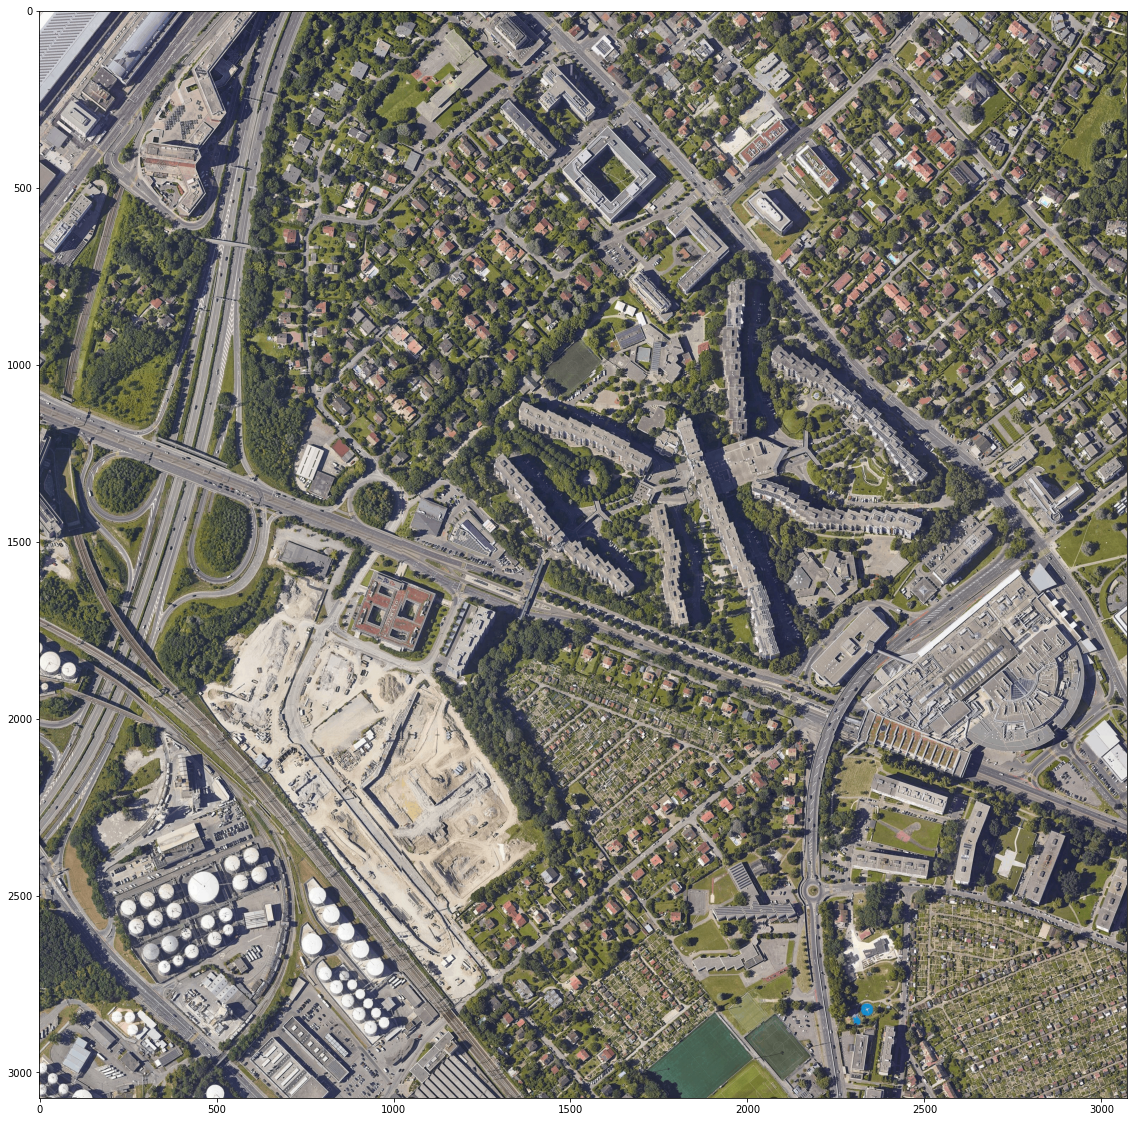

In [15]:
horz_1 = np.hstack([img_1, img_2, img_3])
horz_2 = np.hstack([img_4, img_5, img_6])
horz_3 = np.hstack([img_7, img_8, img_9])

plt.figure(figsize=(20,20))
plt.imshow(np.vstack([horz_1, horz_2, horz_3]))
plt.show()

=> proceed with file ```OpenEarthMap_image_segmentation.ipynb```